# Time sensitive star rating by topic 

In [290]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora, models, similarities
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
import seaborn as sns
import random
import numpy as np
import nltk
from sklearn.model_selection import train_test_split

In [2]:
business = pd.read_csv('chinese_business_clean.csv')
reviews = pd.read_csv('chinese_reviews_clean.csv')

### Study the characteristics of dataset

In [24]:
grouped = reviews.groupby('business_id')
data = []
for i, df in grouped:
    df = df.sort_values(by = 'date')
    data.append({'business_id':i,\
                'review_count':len(df),
                'oldest':df['date'].values[0],\
                'latest':df['date'].values[-1]})

In [33]:
review_stats = pd.DataFrame(data)
review_stats.sort_values(by='review_count', ascending = False).head()

,business_id,latest,oldest,review_count
3692,yfxDa8RFOvJPQh0rNtakHA,2017-07-25,2007-01-03,2446
3088,pH0BLkL4cbxKzu471VZnuA,2017-07-24,2008-07-21,1972
1944,X8c23dur0ll2D9XTu-I8Qg,2017-07-25,2013-04-18,1548
953,GJ_bXUPv672YwNg4TneJog,2017-07-25,2010-12-20,1319
2312,cHdJXLlKNWixBXpDwEGb_A,2017-07-24,2005-11-24,1262


In [40]:
print ('{} businesses'.format(len(review_stats)))

3774 businesses


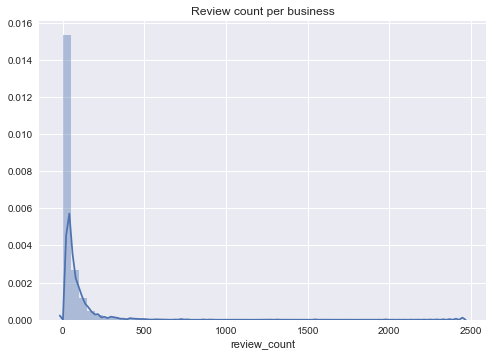

In [39]:
sns.distplot(review_stats['review_count'])
plt.title('Review count per business')
plt.show()

In [60]:
review_stats = review_stats.loc[review_stats['review_count'] > 50]

In [61]:
print ('{} businesses'.format(len(review_stats)))

957 businesses


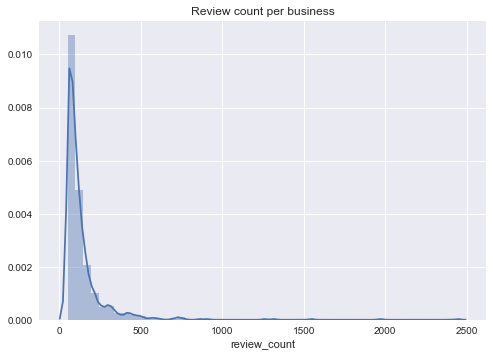

In [62]:
sns.distplot(review_stats['review_count'])
plt.title('Review count per business')
plt.show()

In [70]:
lda =  models.LdaModel.load('gensim/lda.model')
dictionary = corpora.Dictionary.load('gensim/chinsese_dict.dict')

In [85]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

def embed(text, model, dictionary):
    text = tokenize(text)
    bow = dictionary.doc2bow(text)
    kindex = model.get_document_topics(bow)
    out = [0] * model.num_topics
    for i, p in kindex:
        out[i] = p
    return np.array(out) 

def embed_sent(text, model, dictionary):
    out = np.array([0.]*128)
    sentences = len(nltk.sent_tokenize(text))
    for text in nltk.sent_tokenize(text):
        out += embed(text, lda, dictionary)
    return (out/sentences)

In [159]:
embed_sent(reviews['text'][3], lda, dictionary)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00994503,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.06345756,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.04780944,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.04771185,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.18601614,  0.        ,  0.        ,  0.        ,  0.        ,
        0.05662596,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.02196076,  0.        ,  0.05

In [178]:
freq = np.array([0.] * lda.num_topics)
for text in (random.sample(set(reviews['text']), 1000)):
    freq += np.ceil(embed_sent(text, lda, dictionary))  

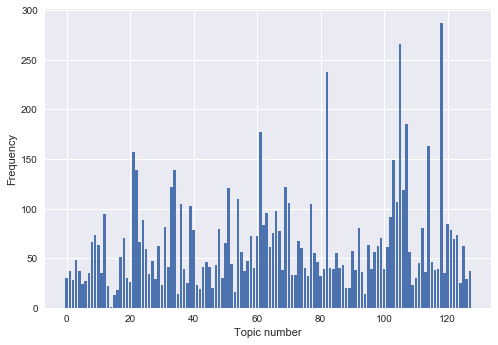

In [179]:
plt.bar(np.arange(lda.num_topics), freq)
plt.xlabel('Topic number')
plt.ylabel('Frequency')
plt.show()

In [183]:
np.argsort(freq)

array([ 14,  15,  35,  94,  53,  16,  42,  88,  46,  89,  13,  41,  30,
       109,   5,  38, 124,  20,   6,   2, 126,  28,   0, 110,  19,  49,
        80,  76,  72,  71,  26, 119,   7,  11,  93, 113,  56, 127,   1,
         4,  68,  91, 116,  96, 117, 100,  84,  81,  37,  75,  59,  83,
        86,  45,  43,  32,  47,  87,  52, 111, 115,  79,  44,  57,  27,
         3,  17,  85,  78, 108,  97,  55,  90,  25,  74,  64, 101,  98,
        29, 125,  10,  95,  50,  23,   8,  73, 122,  18,  99,  58,  60,
       123,   9,  65,  67,  40, 121,  48, 112,  92,  31,  62, 120,  24,
       102,  12,  63,  66,  39,  36,  77,  70, 104,  54, 106,  51,  69,
        33,  34,  22, 103,  21, 114,  61, 107,  82, 105, 118])

In [193]:
print (lda.print_topic(118) + '\n')
print (lda.print_topic(105) + '\n')
print (lda.print_topic(82) + '\n')

0.023*"food" + 0.014*"service" + 0.013*"minutes" + 0.012*"table" + 0.011*"order" + 0.011*"came" + 0.010*"good" + 0.009*"got" + 0.009*"time" + 0.008*"asked"

0.059*"food" + 0.029*"chinese" + 0.023*"place" + 0.018*"good" + 0.017*"service" + 0.013*"restaurant" + 0.012*"great" + 0.008*"authentic" + 0.007*"dishes" + 0.007*"ve"

0.023*"order" + 0.023*"food" + 0.013*"delivery" + 0.012*"called" + 0.011*"place" + 0.010*"ordered" + 0.010*"service" + 0.010*"said" + 0.008*"phone" + 0.008*"like"



People seem to talk about waiting time for food, authenticity, delivery service.

What if we apply '1 topic per sentence rule'

In [211]:
freq = np.array([0.] * lda.num_topics)
for text in (random.sample(set(reviews['text']), 1000)):
    e = embed_sent(text, lda, dictionary)
    i = e.tolist().index(max(e))
    topic = np.array([0.] * lda.num_topics)
    topic[i] = 1.0
    freq += topic

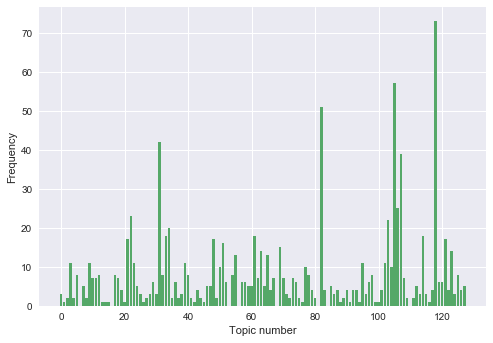

In [213]:
plt.bar(np.arange(lda.num_topics), freq)
plt.xlabel('Topic number')
plt.ylabel('Frequency')
plt.show()

In [214]:
np.argsort(freq)

array([ 84,  81,  68,  53,   6, 110,  16,  56,  99, 100,  20,  88,  45,
        15,  94,  26,  76, 116,  42,  91,   1,  14,  13,  44,  49,  35,
        41,  37,  80, 109, 111,  75,   8,  72,   4,   2,  27,  89,  86,
        71,   0,  25, 124, 115, 113,  30,  96,  28,  38, 122, 117,  79,
        19,  90,  83,  87,  66,  93,  43,  92, 101, 126,  85, 112, 127,
         7,  24,  64,  46,  60,  59,  47,  97,  36, 119, 120,  52,  29,
        57,  58,  74,  10,  62,  67,  11,  70, 108,  18,  73,  17,  12,
         5,  98,  54, 125,  32,  40,  78,  77, 104,  50,  95,   9,   3,
        23,  39, 102,  65,  55,  63, 123,  69,  51, 121,  48,  21,  33,
        61, 114,  34, 103,  22, 106, 107,  31,  82, 105, 118])

In [218]:
# 31 emerged
print (lda.print_topic(31) + '\n')

0.037*"dim" + 0.037*"sum" + 0.017*"place" + 0.015*"good" + 0.013*"food" + 0.011*"like" + 0.009*"service" + 0.008*"chinese" + 0.007*"restaurant" + 0.006*"dishes"



In [274]:
mat =np.array(mat)

In [279]:
np.corrcoef(mat.T)

array([[  1.00000000e+00,  -1.66588565e-02,  -8.13908424e-03, ...,
          7.48073438e-03,   1.16455530e-02,   3.97818544e-02],
       [ -1.66588565e-02,   1.00000000e+00,  -1.34636063e-02, ...,
          4.84978513e-02,  -2.24036314e-02,   9.69961302e-04],
       [ -8.13908424e-03,  -1.34636063e-02,   1.00000000e+00, ...,
         -1.76465317e-02,  -2.11511504e-02,  -1.63986889e-02],
       ..., 
       [  7.48073438e-03,   4.84978513e-02,  -1.76465317e-02, ...,
          1.00000000e+00,  -2.08450439e-02,  -2.46859625e-02],
       [  1.16455530e-02,  -2.24036314e-02,  -2.11511504e-02, ...,
         -2.08450439e-02,   1.00000000e+00,   2.77296803e-02],
       [  3.97818544e-02,   9.69961302e-04,  -1.63986889e-02, ...,
         -2.46859625e-02,   2.77296803e-02,   1.00000000e+00]])

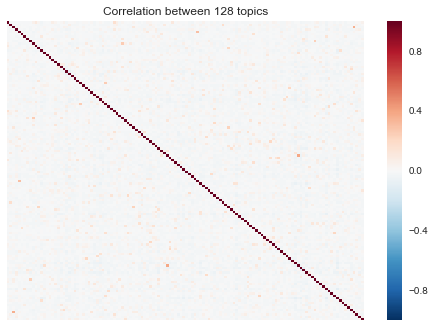

In [289]:
sns.heatmap(np.corrcoef(mat.T), xticklabels='', yticklabels='')
plt.title('Correlation between 128 topics')
plt.show()

## Is topic sufficient to predict star ratings

In [320]:
reviews5 = reviews[reviews['stars'] == 5]

In [331]:
freq = np.array([0.] * lda.num_topics)
for text in (random.sample(set(reviews5['text']), 1000)):
    freq += np.ceil(embed_sent(text, lda, dictionary))

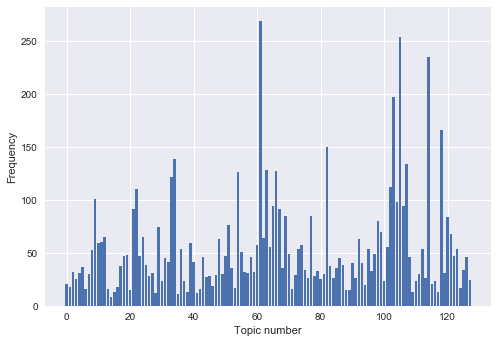

In [332]:
plt.bar(np.arange(lda.num_topics), freq)
plt.xlabel('Topic number')
plt.ylabel('Frequency')
plt.show()

In [333]:
np.argsort(freq)

array([ 14,  35,  28,  41,  38, 117, 109,  15,  20,  89,  88,  42,  71,
        13,   6,  53, 124,  16,   1,  46,  94, 115,   0, 100, 110, 116,
        37,  30, 127,   3,  80,  76,  91,  84, 113,  44,  45,  78,  26,
        72,  47,  49,  81,   7, 111,  27,  57, 119,   4,   2,  59,  56,
        79,  96, 125,  75,  52,  68,  85,   5,  83,  17,  25,  87,  90,
        93,  32,  40,  31,  86,  43,  58, 108, 126,  23,  18,  50, 122,
        19,  97,  70,  55,   8, 123,  73,  95, 112,  36, 101,  64,  60,
        74,  10,  39,  11,  92,  48,  62,  12,  24, 121,  99,  29,  51,
        98, 120,  77,  69,  21,  67, 106,  65, 104,   9,  22, 102,  33,
        54,  66,  63, 107,  34,  82, 118, 103, 114, 105,  61])

In [325]:
reviews1 = reviews[reviews['stars'] == 1]

In [334]:
freq = np.array([0.] * lda.num_topics)
for text in (random.sample(set(reviews1['text']), 1000)):
    freq += np.ceil(embed_sent(text, lda, dictionary))

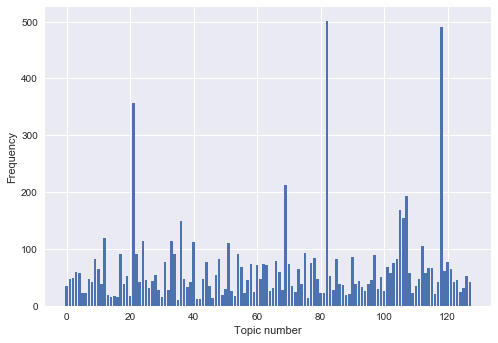

In [335]:
plt.bar(np.arange(lda.num_topics), freq)
plt.xlabel('Topic number')
plt.ylabel('Frequency')
plt.show()

In [336]:
np.argsort(freq)

array([ 35,  41,  42,  76,  46,  30,  14,  16,  15,  20,  53,  88,  13,
        49, 116,  89,  81, 109,  56,  80,   5,   6, 124,  72,  59,  64,
        52, 100,  94,  84,  32,  29,  68,  50,  98,  26,  65, 125,  38,
        93,  71, 110,  45,   0,  87,  95,  74,  86,  91,  11,  18,  39,
       117, 122, 127,   8,  23,  92,  27,  57,  25, 123,  96,  79,   7,
        43,  37,  61,   1, 111,   2,  99,  19, 126,  83,  28,  47, 102,
       113, 108,   4,   3,  67, 119,  10, 121,  73, 115, 114, 101,  55,
        63,  60,  58,  62,  70, 103,  77, 120,  44,  31,  66,   9,  48,
       104,  85,  78,  90,  97,  22,  54,  34,  17,  75, 112,  51,  40,
        24,  33,  12,  36, 106, 105, 107,  69,  21, 118,  82])

In [342]:
print ('Top 3 positive topics')
print (lda.print_topic(61) + '\n')
print (lda.print_topic(105) + '\n')
print (lda.print_topic(114) + '\n')

print ('Top 3 negative topics')
print (lda.print_topic(82) + '\n')
print (lda.print_topic(118) + '\n')
print (lda.print_topic(21) + '\n')

Top 3 positive topics
0.020*"great" + 0.016*"chicken" + 0.016*"food" + 0.012*"soup" + 0.012*"delicious" + 0.012*"service" + 0.011*"place" + 0.009*"fried" + 0.009*"fresh" + 0.008*"sauce"

0.059*"food" + 0.029*"chinese" + 0.023*"place" + 0.018*"good" + 0.017*"service" + 0.013*"restaurant" + 0.012*"great" + 0.008*"authentic" + 0.007*"dishes" + 0.007*"ve"

0.032*"great" + 0.029*"dumplings" + 0.022*"food" + 0.016*"place" + 0.015*"good" + 0.012*"friendly" + 0.012*"soup" + 0.012*"service" + 0.011*"chicken" + 0.010*"staff"

Top 3 negative topics
0.023*"order" + 0.023*"food" + 0.013*"delivery" + 0.012*"called" + 0.011*"place" + 0.010*"ordered" + 0.010*"service" + 0.010*"said" + 0.008*"phone" + 0.008*"like"

0.023*"food" + 0.014*"service" + 0.013*"minutes" + 0.012*"table" + 0.011*"order" + 0.011*"came" + 0.010*"good" + 0.009*"got" + 0.009*"time" + 0.008*"asked"

0.032*"food" + 0.019*"place" + 0.015*"service" + 0.011*"good" + 0.009*"order" + 0.009*"like" + 0.009*"chinese" + 0.007*"time" + 0.006*"

Overwhelming majority of negative reviews are about delivery and waiting time for the food

In [347]:
review_stats.sort_values(by='review_count', ascending = False)['business_id'].values[0]

'yfxDa8RFOvJPQh0rNtakHA'

In [353]:
data = reviews[reviews['business_id'] == 'yfxDa8RFOvJPQh0rNtakHA']
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['stars'], test_size=0.20)

In [354]:
def generate_data(train):
    embed = []
    for text in train:
        embed.append(embed_sent(text, lda, dictionary))
    return np.array(embed)

In [355]:
%time train = generate_data(X_train)

CPU times: user 24.1 s, sys: 81.3 ms, total: 24.2 s
Wall time: 22.5 s


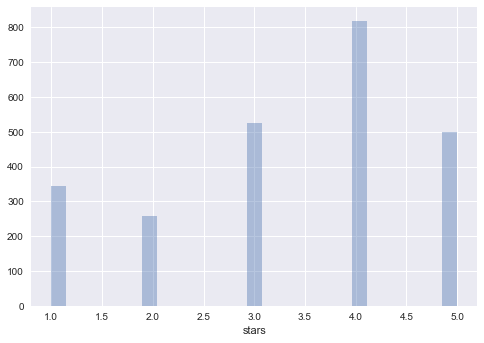

In [362]:
sns.distplot(data['stars'], kde = False)
plt.show()

In [380]:
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [371]:
%time test = generate_data(X_test)

CPU times: user 5.97 s, sys: 19 ms, total: 5.99 s
Wall time: 5.41 s


In [445]:
clf = svm.SVC()
clf.fit(train, y_train)
confusion_matrix(clf.predict(test), y_test)

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [ 73,  60,  95, 162, 100],
       [  0,   0,   0,   0,   0]])

In [444]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(train, y_train)
confusion_matrix(clf.predict(test), y_test)

array([[27, 11, 18, 33, 18],
       [40, 35, 44, 74, 34],
       [ 2,  6,  8, 15,  9],
       [ 2,  5, 12, 25, 19],
       [ 2,  3, 13, 15, 20]])

In [443]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=20, n_estimators=10, max_features=1)
clf.fit(train, y_train)
confusion_matrix(clf.predict(test), y_test)

array([[ 17,   3,   4,   1,   0],
       [  1,   1,   0,   1,   1],
       [ 11,   8,  11,  13,  13],
       [ 39,  40,  71, 134,  75],
       [  5,   8,   9,  13,  11]])

In [442]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=20)
clf.fit(train, y_train)
confusion_matrix(clf.predict(test), y_test)

array([[ 24,  13,   7,   7,   3],
       [  7,   2,   7,   5,   1],
       [ 12,  13,  20,  26,  10],
       [ 26,  31,  48, 106,  69],
       [  4,   1,  13,  18,  17]])

In [441]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(train, y_train)
confusion_matrix(clf.predict(test), y_test)

array([[ 35,  12,   8,  16,   4],
       [  6,   4,   6,   3,   0],
       [ 19,  22,  16,  18,  14],
       [  9,  21,  58, 103,  60],
       [  4,   1,   7,  22,  22]])

In [493]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (100, 95, 80, 75), activation = 'tanh', alpha=0.2, learning_rate = 'adaptive')
clf.fit(train, y_train)
confusion_matrix(clf.predict(test), y_test)

array([[ 47,  15,   6,  10,   7],
       [  1,   4,   4,   1,   1],
       [ 15,  14,  22,  27,  16],
       [  8,  25,  53, 107,  57],
       [  2,   2,  10,  17,  19]])